# Models

In [3]:
import time
import datetime
import numpy as np
import pandas as pd
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from pprint import pprint
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# %run /content/drive/MyDrive/DentistDataAnalysis/Experiments/Mappings.ipynb
%run Mappings.ipynb

In [5]:
# DIR = '/content/drive/MyDrive/DentistDataAnalysis/Experiments/'
DIR = ''

In [6]:
data = pd.read_csv(DIR+'dataset/final_data.csv')

In [7]:
X_cols = ['Que1', 'Que2', 'Que3', 'Que4', 'Que5', 'Que6', 'Que10_a', 'Que10_b', 'Que10_c', 'Que10_d', 'Que10_e', 'Que10_f', 'Que14', 'Que15', 'Que17', 'Que18_age', 'Que19', 'Que20', 'Que21', 'Que22', 'Que_smoking']
y_col = ['Que16']

## Logit

In [8]:
def perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col):
    X_train_df = pd.DataFrame(data=X_train, columns=X_cols)
    y_train_df = pd.DataFrame(data=y_train, columns=y_col)
    logit = Logit(y_train_df, X_train_df)
    lg = logit.fit()
    print(lg.summary())
    yhat = lg.predict(X_test)
    prediction = list(map(round, yhat))
    get_metrics(y_test, prediction)

## Random forest

In [9]:
def perform_random_forest(X_train, y_train, X_test, y_test):
    #hyperparameters config
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 150, num = 15)]
    criterion = ['gini', 'entropy']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 100, num = 6)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]
    random_grid = {'n_estimators': n_estimators,
                   'criterion': criterion,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    #grid search config
    rf_scoring='accuracy'
    rf_cv = 5
    rf_verbose=1
    rf_n_jobs=-1
    rf_return_train_score=True
    rf = RandomForestClassifier()
    rf_grid = GridSearchCV(estimator=rf, 
                            param_grid=random_grid,
                            scoring=rf_scoring, cv=rf_cv, 
                            verbose=rf_verbose, n_jobs=rf_n_jobs, 
                            return_train_score=rf_return_train_score)
    start_time = time.time()
    rf_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    pprint(rf_grid.best_params_)
    prediction = rf_grid.best_estimator_.predict(X_test)
    get_metrics(y_test, prediction)
    
    start_time = time.time()
    importances = rf_grid.best_estimator_.feature_importances_
    std = np.std([rf_grid.best_estimator_.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: " 
          f"{elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=X_cols)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

## Decision trees

In [27]:
def perform_decision_tree(X_train, y_train, X_test, y_test):
    #hyperparameters config
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 50, num = 6)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    random_grid = {'criterion': criterion,
                   'splitter': splitter,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    #decision trees config
    dtc_scoring='accuracy'
    dtc_cv = 5
    dtc_verbose=1
    dtc_n_jobs=-1
    dtc_return_train_score=True
    dtc = DecisionTreeClassifier()
    dtc_grid = GridSearchCV(estimator=dtc, 
                            param_grid=random_grid,
                            scoring=dtc_scoring, cv=dtc_cv, 
                            verbose=dtc_verbose, n_jobs=dtc_n_jobs, 
                            return_train_score=dtc_return_train_score)
    start_time = time.time()
    dtc_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    pprint(dtc_grid.best_params_)
    prediction = dtc_grid.best_estimator_.predict(X_test)
    get_metrics(y_test, prediction)

## Metrics

In [32]:
def get_metrics(y_true, prediction):
    print(np.unique(y_true, return_counts=True))
    print('Test ROC AUC:\t', roc_auc_score(y_true, prediction))
    print('Test accuracy:\t', accuracy_score(y_true, prediction))
    print('Test precision:\t', precision_score(y_true, prediction))
    print('Test recall:\t', recall_score(y_true, prediction))
    print('Test F1 score:\t', f1_score(y_true, prediction))
    print('Test confusion matrix:\t')
    print(confusion_matrix(y_true, prediction))

# Strategy 1 - dropping all missing

In [33]:
data_dropped = data.dropna().reset_index(drop=True)
data_dropped = perform_mapping(data_dropped, questions_map_EN)
model_data = data_dropped.drop(columns=['Que16'])
target_data = data_dropped['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [34]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Optimization terminated successfully.
         Current function value: 0.568071
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  748
Model:                          Logit   Df Residuals:                      727
Method:                           MLE   Df Model:                           20
Date:                Mon, 30 Aug 2021   Pseudo R-squ.:                  0.1293
Time:                        15:54:23   Log-Likelihood:                -424.92
converged:                       True   LL-Null:                       -488.02
Covariance Type:            nonrobust   LLR p-value:                 2.008e-17
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Que1            0.4411      0.244      1.808      0.071      -0.037       0.919
Que2           -0.3173    

### Undersampling

In [14]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Optimization terminated successfully.
         Current function value: 0.609852
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  536
Model:                          Logit   Df Residuals:                      515
Method:                           MLE   Df Model:                           20
Date:                Mon, 30 Aug 2021   Pseudo R-squ.:                  0.1202
Time:                        15:32:49   Log-Likelihood:                -326.88
converged:                       True   LL-Null:                       -371.53
Covariance Type:            nonrobust   LLR p-value:                 9.854e-11
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Que1            0.6981      0.273      2.553      0.011       0.162       1.234
Que2           -0.4400    

### Oversampling

In [15]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Optimization terminated successfully.
         Current function value: 0.609854
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  960
Model:                          Logit   Df Residuals:                      939
Method:                           MLE   Df Model:                           20
Date:                Mon, 30 Aug 2021   Pseudo R-squ.:                  0.1202
Time:                        15:32:51   Log-Likelihood:                -585.46
converged:                       True   LL-Null:                       -665.42
Covariance Type:            nonrobust   LLR p-value:                 7.768e-24
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Que1            0.4833      0.203      2.382      0.017       0.086       0.881
Que2           -0.4388    

### SMOTEENN

In [16]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Optimization terminated successfully.
         Current function value: 0.390417
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  491
Model:                          Logit   Df Residuals:                      470
Method:                           MLE   Df Model:                           20
Date:                Mon, 30 Aug 2021   Pseudo R-squ.:                  0.4049
Time:                        15:32:52   Log-Likelihood:                -191.69
converged:                       True   LL-Null:                       -322.10
Covariance Type:            nonrobust   LLR p-value:                 7.522e-44
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Que1            1.7548      0.410      4.279      0.000       0.951       2.558
Que2           -0.6201    

## Random Forest

### No balance

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:03:11.283271
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 46,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 118}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.6637775370169736
Test accuracy:  0.7021276595744681
Test precision:  0.732824427480916
Test recall:  0.8205128205128205
Test F1 score:  0.7741935483870968
Test confusion matrix: 
[[36 35]
 [21 96]]
Elapsed time to compute the importances: 1.070 seconds


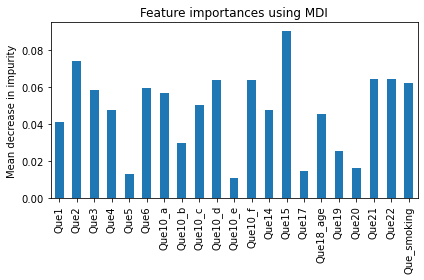

In [17]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:02:50.452045
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 46,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 56}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.6276032261947755
Test accuracy:  0.6329787234042553
Test precision:  0.7307692307692307
Test recall:  0.6495726495726496
Test F1 score:  0.6877828054298643
Test confusion matrix: 
[[43 28]
 [41 76]]
Elapsed time to compute the importances: 0.213 seconds


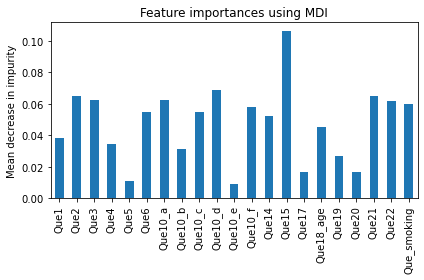

In [18]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:02:59.807065
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 46,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 129}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.6479475141446972
Test accuracy:  0.675531914893617
Test precision:  0.7295081967213115
Test recall:  0.7606837606837606
Test F1 score:  0.7447698744769875
Test confusion matrix: 
[[38 33]
 [28 89]]
Elapsed time to compute the importances: 1.121 seconds


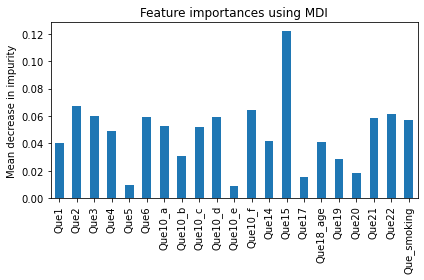

In [19]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:02:37.944196
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.6892379920548936
Test accuracy:  0.6648936170212766
Test precision:  0.8214285714285714
Test recall:  0.5897435897435898
Test F1 score:  0.6865671641791046
Test confusion matrix: 
[[56 15]
 [48 69]]
Elapsed time to compute the importances: 0.045 seconds


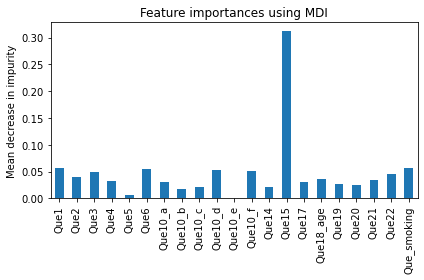

In [20]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [28]:
perform_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:01.292302
{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.6107499699048995
Test accuracy:  0.6223404255319149
Test precision:  0.7129629629629629
Test recall:  0.6581196581196581
Test F1 score:  0.6844444444444444
Test confusion matrix: 
[[40 31]
 [40 77]]


### Undersampling

In [29]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:01.045131
{'criterion': 'entropy',
 'max_depth': 34,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.5805946791862285
Test accuracy:  0.574468085106383
Test precision:  0.6989247311827957
Test recall:  0.5555555555555556
Test F1 score:  0.6190476190476191
Test confusion matrix: 
[[43 28]
 [52 65]]


### Oversampling

In [30]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:01.140947
{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.5979294570843867
Test accuracy:  0.6063829787234043
Test precision:  0.7047619047619048
Test recall:  0.6324786324786325
Test F1 score:  0.6666666666666666
Test confusion matrix: 
[[40 31]
 [43 74]]


### SMOTEENN

In [31]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:00.989044
{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:  0.658300228722764
Test accuracy:  0.6436170212765957
Test precision:  0.7777777777777778
Test recall:  0.5982905982905983
Test F1 score:  0.6763285024154589
Test confusion matrix: 
[[51 20]
 [47 70]]


# Strategy 2 - median

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_median = pd.DataFrame(imputer.fit_transform(data))
data_median.columns = data.columns
data_median.index = data.index
data_median = perform_mapping(data_median, questions_map_EN)
model_data = data_median.drop(columns=['Que16'])
target_data = data_median['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [ ]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

### Undersampling

In [ ]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

### Oversampling

In [ ]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

### SMOTEENN

In [ ]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, X_test, y_train, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

# Strategy 3 - mean

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_mean = pd.DataFrame(imputer.fit_transform(data))
data_mean.columns = data.columns
data_mean.index = data.index
# mean values are not integer numbers so rounding to int was necessary
data_mean = data_mean.round()
data_mean = perform_mapping(data_mean, questions_map_EN)
model_data = data_mean.drop(columns=['Que16'])
target_data = data_mean['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [ ]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

### Undersampling

In [ ]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

### Oversampling

In [ ]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

### SMOTEENN

In [ ]:
perform_logit(X_train, X_test, y_train, y_test, X_cols, y_col, balance='smoteen')

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, X_test, y_train, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

# Strategy 4 - most frequent

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_most_frequent = pd.DataFrame(imputer.fit_transform(data))
data_most_frequent.columns = data.columns
data_most_frequent.index = data.index
# mean values are not integer numbers so rounding to int was necessary
data_most_frequent = perform_mapping(data_most_frequent, questions_map_EN)
model_data = data_most_frequent.drop(columns=['Que16'])
target_data = data_most_frequent['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [ ]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

### Undersampling

In [ ]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

### Oversampling

In [ ]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

### SMOTEENN

In [ ]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train, X_test, y_train, y_test, balance='smoteen')

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, X_test, y_train, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)